Use bees4 conda env

In [4]:
#!pip install tensorflow_addons==0.12.1

In [5]:
#!pip install keras

In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from PIL import Image as Image2
import matplotlib.pyplot as plt
from data_augmentation import random_rotation, random_translation
from data import filename2image
import pandas as pd
import yaml
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
import numpy as np

In [53]:
# Occlusion Mask Functions

def pseudo_occlusion_sensitivity_color(model, X, reference, color_index, occlusion_size=1, stride=1, occlusion_value=0, verbose=False):
    if occlusion_size < 1:
        print(f'ERROR - invalid occlusion size {occlusion_size}')
        print(f'Using a value of 1 instead')
        occlusion_size = 1
    if occlusion_size%2 == 0:
        print(f'WARNING - occlusion size not odd: {occlusion_size}')
        print(f'Using a value of {occlusion_size+1} instead')
        occlusion_size+=1
    output = np.zeros((X.shape[0], X.shape[1]))
    averaging_mask = np.zeros((X.shape[0], X.shape[1]))
    if verbose:
        print(f'X shape: {X.shape}')
        print(f'output shape: {output.shape}')

    # Get the total number of occlusion windows
    n_windows = ((X.shape[0] // stride) + 1) * ((X.shape[1] // stride) + 1)

    # Create an array to store all occluded images
    occluded_images = np.empty((n_windows, X.shape[0], X.shape[1], X.shape[2]))

    # Create an array to store the indices of the occluded windows
    indices = np.empty((n_windows, 4), dtype=int)

    count = 0
    for j in range(0, X.shape[0]+1, stride):
        for k in range(0, X.shape[1]+1, stride):
            x_occluded = X.copy()
            x1, x2 = max(0, j-int((occlusion_size-1)/2)), min(X.shape[0], j+int(occlusion_size/2)+1)
            y1, y2 = max(0, k-int((occlusion_size-1)/2)), min(X.shape[1], k+int(occlusion_size/2)+1)
            x_occluded[x1:x2, y1:y2] = occlusion_value
            occluded_images[count] = x_occluded
            indices[count] = np.array([x1, x2, y1, y2])
            count += 1

    # Now we can make predictions for all occluded images at once
    predictions = model.predict(occluded_images)

    # Then we update the output and averaging_mask arrays for each occluded window
    for i in range(n_windows):
        x1, x2, y1, y2 = indices[i]
        #diff = np.abs(predictions[i][color_index] - reference)
        diff = predictions[i][color_index] - reference
        output[x1:x2, y1:y2] += diff
        averaging_mask[x1:x2, y1:y2] += 1
    #print(output.shape)
    output = -1.0 * np.divide(output, averaging_mask)
    return output

def pseudo_occlusion_sensitivity_reID(model, X, reference, occlusion_size=1, stride=1, occlusion_value=0, verbose=False):
    if occlusion_size < 1:
        print(f'ERROR - invalid occlusion size {occlusion_size}')
        print(f'Using a value of 1 instead')
        occlusion_size = 1
    if occlusion_size%2 == 0:
        print(f'WARNING - occlusion size not odd: {occlusion_size}')
        print(f'Using a value of {occlusion_size+1} instead')
        occlusion_size+=1

    output = np.zeros((X.shape[0], X.shape[1]))
    averaging_mask = np.zeros((X.shape[0], X.shape[1]))

    if verbose:
        print(f'X shape: {X.shape}')
        print(f'output shape: {output.shape}')

    # Get the total number of occlusion windows
    n_windows = ((X.shape[0] // stride) + 1) * ((X.shape[1] // stride) + 1)

    # Create an array to store all occluded images
    occluded_images = np.empty((n_windows, X.shape[0], X.shape[1], X.shape[2]))

    # Create an array to store the indices of the occluded windows
    indices = np.empty((n_windows, 4), dtype=int)

    count = 0
    for j in range(0, X.shape[0]+1, stride):
        for k in range(0, X.shape[1]+1, stride):
            x_occluded = X.copy()
            x1, x2 = max(0, j-int((occlusion_size-1)/2)), min(X.shape[0], j+int(occlusion_size/2)+1)
            y1, y2 = max(0, k-int((occlusion_size-1)/2)), min(X.shape[1], k+int(occlusion_size/2)+1)
            x_occluded[x1:x2, y1:y2] = occlusion_value
            occluded_images[count] = x_occluded
            indices[count] = np.array([x1, x2, y1, y2])
            count += 1


    print(f'Length of occluded_images: {len(occluded_images)}')

    # Now we can make predictions for all occluded images at once
    predictions = model.predict(occluded_images)

    
    # Then we update the output and averaging_mask arrays for each occluded window
    for i in range(n_windows):
        x1, x2, y1, y2 = indices[i]
        diff = 1.0 - np.dot(predictions[i], reference)
        output[x1:x2, y1:y2] += diff
        averaging_mask[x1:x2, y1:y2] += 1
    #print(output.shape)
    output = np.divide(output, averaging_mask)
    return output

    
def get_occlusion_maps_reID(model, samples, color, occlusion_size=5, stride=3, occlusion_value=0, verbose=False):
    ref_value = model.predict(samples)
    results = []
    start = time.time()
    for k in range(samples.shape[0]):
        temp = pseudo_occlusion_sensitivity_reID(model, samples[k], ref_value[k], occlusion_size, stride, occlusion_value, verbose)
        results.append(temp)
    stop = time.time()
    print('Total time:',(stop-start)/60)
    return results



In [22]:
# Plotting Functions

def plot_occlusion_maps(samples, occlusions, savefig=False, figname=None):
    plt.figure(figsize=(20,5))
    N = samples.shape[0]
    for k in range(N):
        ax = plt.subplot(2,N,k+1)
        ax.axis('off')
        plt.imshow(samples[k])
        ax2 = plt.subplot(2,N,(N+1)+k)
        ax2.axis('off')
        plt.imshow(results[k], cmap='bwr')
    if savefig:
        plt.savefig(figname)
    plt.show()
    
    
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255,255/255,0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [33]:
config_file = 'sample_model_train_SCL_config_500balanced.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)
model_config = config['model_settings'] # settings for model building
train_config = config['train_settings'] # settings for model training
data_config = config['data_settings'] # settings for data loading
config_dir = config['config_dir'] # directory where copy of config will be stored
models_csv = config['models_csv'] # csv containing info about all trained models
#eval_config = config['eval_settings']

In [34]:
#from data import *
#df = load_data(data_config)
print(data_config)

{'dataset': 'young_adult_bees', 'split_type': 'closed', 'train_fname': 'dataset_young_adult_train_closed_2023JUL28_balanced_500id.csv', 'valid_fname': 'dataset_young_adult_valid_closed_2023JUL28_balanced_500id.csv', 'label_col': 'label', 'fname_col': 'filename', 'input_size': [256, 256, 3], 'norm_method': 1, 'mean': None, 'std': None, 'cropped': False, 'h_range': None, 'w_range': None, 'augmentation': True, 'aug_methods': ['r_translate', 'r_rotate', 'r_bright', 'r_contrast'], 'aug_p': 0.4, 'bright_delta': 0.3, 'cont_lower': 0.5, 'cont_upper': 2, 'rotate_min': 0, 'rotate_max': 4.71, 'translate_hrange': [-25, 25], 'translate_wrange': [-25, 25]}


In [35]:
#df = pd.DataFrame.from_dict(data_config)
#df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data_config.items() ]))
print(model_config)

{'model_type': 'SCL', 'backbone': 'resnet50v2', 'head': None, 'weights': None, 'output_layer_name': 'conv3_block4_out', 'first_trainable_layer_name': None, 'latent_dim': 128, 'dropout': True, 'dropout_first': 0.5, 'dropout_last': 0.2, 'l2_norm': True, 'GAP': False, 'model_folder': None, 'models_dir': '/home/rmelendez/github/bee_id/MODELS/'}


In [39]:
df = pd.read_csv(data_config['train_fname'])
df.shape

(8487, 5)

In [28]:
N_samples = 20
occlusion_size = 11 #must be odd
stride = 5

In [29]:
model_folder = '/home/agomez/PythonScripts/MODEL/SCL_DataTotal_Balanced_Augmentation_500id/model.tf' # cambia por el path de tu modelo (el path debe terminar con ".tf")
model = load_model(model_folder, custom_objects={'tf':tf})

/home/jrodriguez/anaconda3/envs/bees4/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [55]:
samples = df.sample(N_samples).filename.values
samples = filename2image(samples, data_config)
#samples = next(iter(samples.batch(10))).numpy()
samples = next(iter(samples.batch(1))).numpy()

print(samples[0].shape)

results = get_occlusion_maps_reID(model, samples, 'color', occlusion_size=occlusion_size, stride=stride, occlusion_value=0, verbose=False)


(256, 256, 3)
Length of occluded_images: 2704
Total time: 2.3936977783838906


In [52]:
results[0].shape

(256, 256)

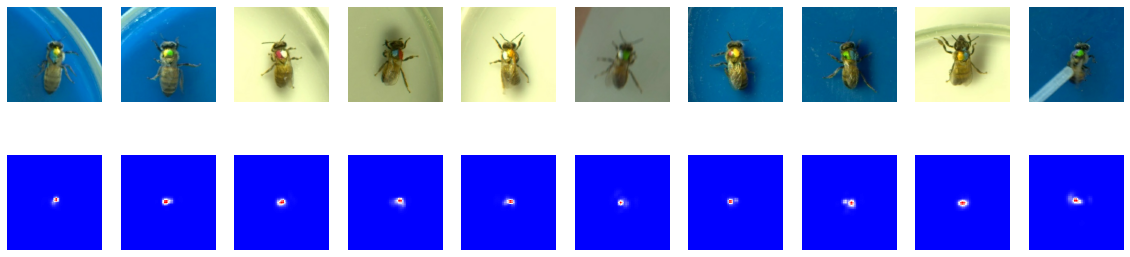

In [41]:
plot_occlusion_maps(samples, results, savefig=False, figname=None)

<class 'numpy.ndarray'>


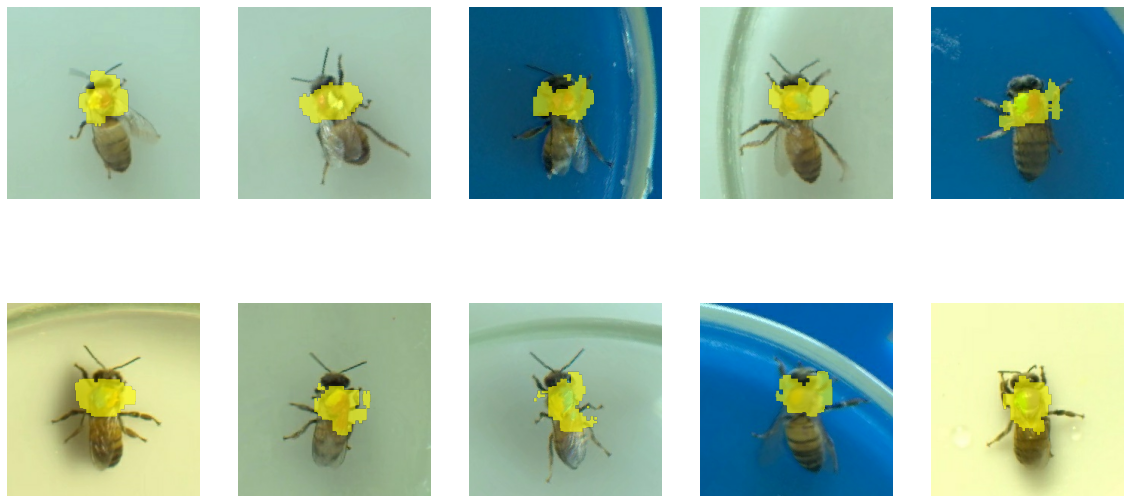

In [25]:
results2 = np.array(results).copy()
print(type(results2))
for k in range(results2.shape[0]):
    results2[k] = (results2[k] > np.quantile(results2[k], 0.95)).astype(int)

plt.figure(figsize=(20,10))
for k in range(samples.shape[0]):  
    ax = plt.subplot(2,5,k+1)
    ax.axis('off')
    plt.imshow(samples[k])
    show_mask(results2[k], ax)
plt.show()

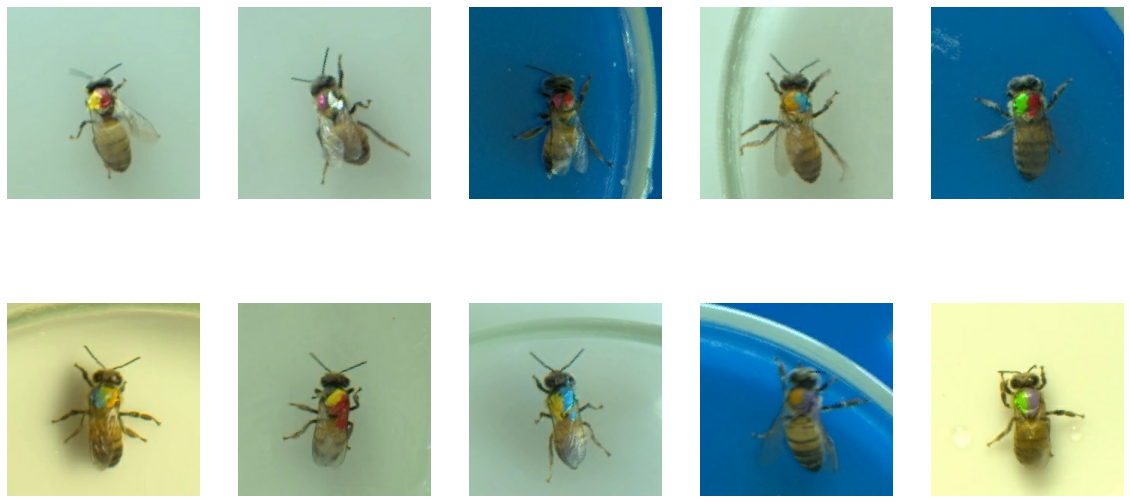

In [26]:
plt.figure(figsize=(20,10))
for k in range(samples.shape[0]):  
    ax = plt.subplot(2,5,k+1)
    ax.axis('off')
    plt.imshow(samples[k])
plt.show()

In [ ]:
samples_aug = np.zeros((samples.shape))
for k in range(samples.shape[0]):
    img = random_translation(samples[k], p=1.0, height_range=[1,5], width_range=[1,5])
    img = random_rotation(samples[k], p=1.0, minval=-np.pi/3.0, maxval=np.pi/3.0).numpy()
    samples_aug[k] = img
    
results = get_occlusion_maps_reID(model, samples_aug, 'color', occlusion_size=5, stride=2, occlusion_value=0, verbose=False)
plot_occlusion_maps(samples_aug, results, savefig=False, figname=None)

/home/agomez/.conda/envs/bees4/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)
/home/agomez/.conda/envs/bees4/lib/python3.7/site-packages/tensorflow_addons/image/transform_ops.py:143: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  "fill_value is not supported and is always 0 for TensorFlow < 2.4.0."


In [ ]:
results2 = np.array(results).copy()
for k in range(results2.shape[0]):
    results2[k] = (results2[k] > np.quantile(results2[k], 0.90)).astype(int)
plt.figure(figsize=(20,10))
for k in range(samples_aug.shape[0]):  
    ax = plt.subplot(1,N_samples,k+1)
    plt.imshow(samples[k])
    show_mask(results2[k], ax)
plt.show()